In [5]:
# DATASET

import h5py
import torch
from torch.utils.data import Dataset, DataLoader, BatchSampler, RandomSampler

class ChessHiddenStateDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        with h5py.File(self.file_path, 'r') as f:
            self.total_positions = f['lc0_hidden'].shape[0]
            self.num_games = self.total_positions // 10
            print(f"Adatok: {self.total_positions} állás, ami {self.num_games} teljes játék.")

        self.archive = None

    def __len__(self):
        return self.num_games

    def __getitem__(self, idx):
        if self.archive is None:
            self.archive = h5py.File(self.file_path, 'r', swmr=True)
        
        start = int(idx) * 10
        state = self.archive['lc0_hidden'][start : start + 10]
        
        if state.shape[0] != 10:
            state = self.archive['lc0_hidden'][0:10]
            
        return torch.from_numpy(state).float() 


In [6]:
# DATALOADER

import numpy as np
from torch.utils.data import Subset, DataLoader

batch_size_in_games = 128
val_data_ratio = 0.15
test_data_ratio = 0.15
file_path = "data/lc0-hidden/lichess_elite_2025-11.h5"
dataset = ChessHiddenStateDataset(file_path)

dataset_size = len(dataset)
indices = list(range(dataset_size))

val_split = int(np.floor(val_data_ratio * dataset_size)) 
test_split = int(np.floor(test_data_ratio * dataset_size)) 

np.random.seed(42)
np.random.shuffle(indices)

test_indices = indices[:test_split]
val_indices = indices[test_split : test_split + val_split]
train_indices = indices[test_split + val_split :]

train_dataset = Subset(dataset, train_indices)
val_dataset   = Subset(dataset, val_indices)
test_dataset  = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size_in_games, 
                          shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

val_loader   = DataLoader(val_dataset, batch_size=batch_size_in_games, 
                          shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

test_loader  = DataLoader(test_dataset, batch_size=batch_size_in_games, 
                          shuffle=False, num_workers=0, pin_memory=True, drop_last=True)

print(f"Összes játék:  {dataset_size}")
print(f"Tanító (70%):  {len(train_dataset)}")
print(f"Validációs (15%): {len(val_dataset)}")
print(f"Teszt (15%):     {len(test_dataset)}")



Adatok: 100000 állás, ami 10000 teljes játék.
Összes játék:  10000
Tanító (70%):  7000
Validációs (15%): 1500
Teszt (15%):     1500


In [11]:
# ENCODER

import torch.nn as nn

class ChessEncoder(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ChessEncoder, self).__init__()
        
        # Conv block
        self.conv_block = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # MLP
        self.mlp = nn.Sequential(
            nn.Flatten(),  # 64 * 8 * 8 = 4096
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, embedding_dim) 
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.mlp(x)
        return x

In [12]:
# LOSS FUNCTION

import torch
import torch.nn.functional as F

def multi_positive_loss(embeddings, group_size=10, temperature=0.07):
    z = F.normalize(embeddings, dim=1)
    
    sim_matrix = torch.matmul(z, z.T) / temperature     # [batch_size, batch_size]
    
    batch_size = embeddings.shape[0]
    mask = torch.zeros((batch_size, batch_size), device=embeddings.device)
    
    for i in range(0, batch_size, group_size):
        mask[i:i+group_size, i:i+group_size] = 1
        
    logits_mask = torch.scatter(
        torch.ones_like(mask, device=embeddings.device),                  # [batch_size, batch_size] meretu 1-esekbol allo mtx
        1,                                      # dim=1, soronkent 
        torch.arange(batch_size).view(-1, 1).to(embeddings.device),   # oszlopindex
        0                                       # nullat irunk a diagonalisba
    ).to(embeddings.device)                     # logits_mask: 1-esekbol allo matrix ahol a diagonalisok 0-ak
    mask = mask * logits_mask                   # mask: diagonalisban 10x10-es blokkok 1-esekkel feltoltve, de a diagonalisok 0-ak

    logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
    logits = sim_matrix - logits_max.detach()       # numerikus stabilitas miatt

    exp_logits = torch.exp(logits) * logits_mask    # szimilaritasok exp-re emelve, a diagonalisok kinullazva
    log_sum_exp_denominator = torch.log(exp_logits.sum(1, keepdim=True))    # a fenti sorosszege egy vektorban
    log_prob = logits - log_sum_exp_denominator     # logaritmus argumentumaban osztas kivonaskent

    # log_prob: (i,j) eleme azt a valsz-et adja, hogy amennyiben i az anchor, j pozitiv

    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)     # diagonalisakat ujbol kinullazzuk, sorosszeg, normalva a pozitivak szamaval
    
    loss = -mean_log_prob_pos.mean()
    return loss

In [13]:
# TRAIN

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChessEncoder(embedding_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 100 
patience = 5    
min_delta = 0.001 

train_loss_history = []
val_loss_history = []
best_loss = float('inf')
patience_counter = 0
best_model_state = None

print(f"Tanítás indítása {device} eszközön (Early Stopping bekapcsolva)...")

model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for states in train_loader:
        input_states = states.view(-1, 64, 8, 8).to(device)
        
        optimizer.zero_grad()
        embeddings = model(input_states)
        loss = multi_positive_loss(embeddings, group_size=10, temperature=0.07)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for states in val_loader:
            input_states = states.view(-1, 64, 8, 8).to(device)
            embeddings = model(input_states)
            loss = multi_positive_loss(embeddings, group_size=10)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        torch.save(best_model_state, 'best_chess_model.pth')
        print(f"  --> Új legjobb modell mentve! (Loss: {best_loss:.4f})")

    else:
        patience_counter += 1
        print(f"  --> Nem javult. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(f"\n[Early Stopping] A tanítás megállt a(z) {epoch+1}. epochnál.")
        model.load_state_dict(best_model_state)
        break

Tanítás indítása cpu eszközön (Early Stopping bekapcsolva)...


/home/csoma/Desktop/ELTE/3/NEURON/PROJEKT/neuron-chess/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1: Train Loss: 6.0744, Val Loss: 5.3224
  --> Új legjobb modell mentve! (Loss: 5.3224)
Epoch 2: Train Loss: 5.0572, Val Loss: 5.0475
  --> Új legjobb modell mentve! (Loss: 5.0475)
Epoch 3: Train Loss: 4.8044, Val Loss: 4.9725
  --> Új legjobb modell mentve! (Loss: 4.9725)
Epoch 4: Train Loss: 4.6311, Val Loss: 4.9441
  --> Új legjobb modell mentve! (Loss: 4.9441)
Epoch 5: Train Loss: 4.4866, Val Loss: 4.9578
  --> Nem javult. Patience: 0/5
Epoch 6: Train Loss: 4.3423, Val Loss: 4.9831
  --> Nem javult. Patience: 1/5
Epoch 7: Train Loss: 4.1991, Val Loss: 5.0177
  --> Nem javult. Patience: 2/5
Epoch 8: Train Loss: 4.0535, Val Loss: 5.1008
  --> Nem javult. Patience: 3/5
Epoch 9: Train Loss: 3.9020, Val Loss: 5.1559
  --> Nem javult. Patience: 4/5

[Early Stopping] A tanítás megállt a(z) 9. epochnál.


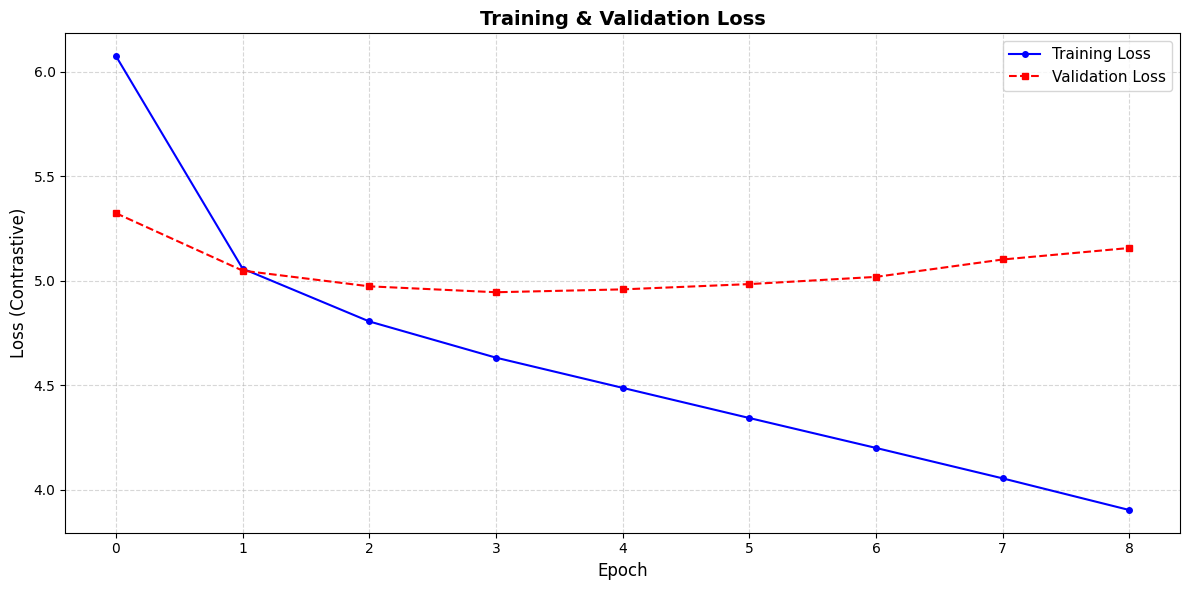

In [14]:
# VISUALIZE LOSS

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(train_loss_history, label='Training Loss', color='blue', marker='o', markersize=4, linestyle='-')

plt.plot(val_loss_history, label='Validation Loss', color='red', marker='s', markersize=4, linestyle='--')

plt.title('Training & Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Contrastive)', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

Vizualizáció előkészítése cpu eszközön...
Betanított modell súlyai sikeresen betöltve.
t-SNE futtatása a tanítatlan modellen...
t-SNE futtatása a betanított modellen...


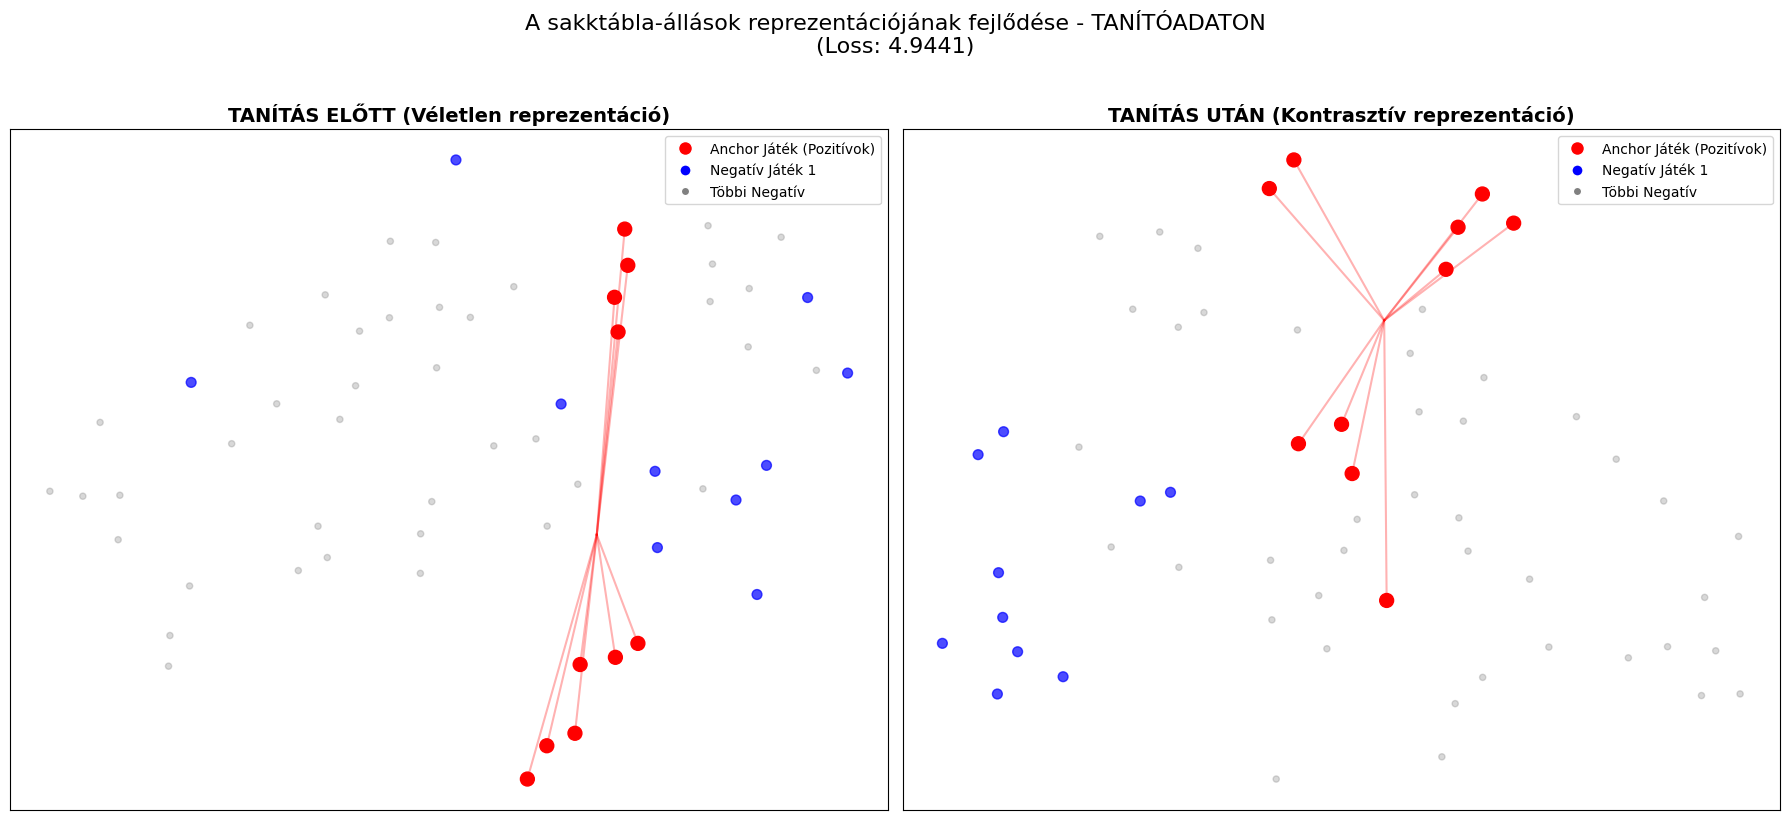

In [ ]:
# VISUALIZATION ON TRAINING DATA
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import DataLoader

FILE_PATH = "data/lc0-hidden/lichess_elite_2025-11.h5"
MODEL_PATH = 'data/lc0-hidden/best_chess_model.pth' 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE_VIZ = 6 

print(f"Vizualizáció előkészítése {DEVICE} eszközön...")

loader_viz = DataLoader(train_dataset, batch_size=BATCH_SIZE_VIZ, shuffle=False, num_workers=0)
viz_states_batch = next(iter(loader_viz))
# Kilapítjuk: [6, 10, 64, 8, 8] -> [60, 64, 8, 8]
viz_states_flat = viz_states_batch.view(-1, 64, 8, 8).to(DEVICE)

labels = np.repeat(np.arange(BATCH_SIZE_VIZ), 10)
colors = ['red' if l == 0 else 'blue' if l == 1 else 'gray' for l in labels]
sizes = [100 if l == 0 else 50 if l == 1 else 20 for l in labels]
alphas = [1.0 if l == 0 else 0.7 if l == 1 else 0.3 for l in labels]


model_untrained = ChessEncoder(embedding_dim=128).to(DEVICE)
model_untrained.eval()

model_trained = ChessEncoder(embedding_dim=128).to(DEVICE)
try:
    model_trained.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("Betanított modell súlyai sikeresen betöltve.")
except FileNotFoundError:
    print(f"HIBA: Nem található az elmentett modell az {MODEL_PATH} útvonalon")
model_trained.eval()


# GENERATING EMBEDDINGS & T-SNE
def get_embeddings_and_tsne(model, inputs):
    with torch.no_grad():
        embeddings = model(inputs).cpu().numpy()
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

print("t-SNE futtatása a tanítatlan modellen...")
emb_untrained_2d = get_embeddings_and_tsne(model_untrained, viz_states_flat)

print("t-SNE futtatása a betanított modellen...")
emb_trained_2d = get_embeddings_and_tsne(model_trained, viz_states_flat)


# VISUALIZATION
def plot_embeddings(embeddings_2d, title, ax):
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=sizes, alpha=alphas)

    anchor_points = embeddings_2d[0:10]
    centroid = np.mean(anchor_points, axis=0)
    for point in anchor_points:
        ax.plot([centroid[0], point[0]], [centroid[1], point[1]], 'r-', alpha=0.3)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Anchor Játék (Pozitívok)', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Negatív Játék 1', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Többi Negatív', markerfacecolor='gray', markersize=6),
    ]
    ax.legend(handles=legend_elements, loc='best')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

plot_embeddings(emb_untrained_2d, "TANÍTÁS ELŐTT (Véletlen reprezentáció)", ax1)
plot_embeddings(emb_trained_2d, "TANÍTÁS UTÁN (Kontrasztív reprezentáció)", ax2)

plt.suptitle(f"A sakktábla-állások reprezentációjának fejlődése - TANÍTÓADATON\n(Loss: {best_loss:.4f})", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Vizualizáció előkészítése cpu eszközön...
Betanított modell súlyai sikeresen betöltve.
t-SNE futtatása a tanítatlan modellen...
t-SNE futtatása a betanított modellen...


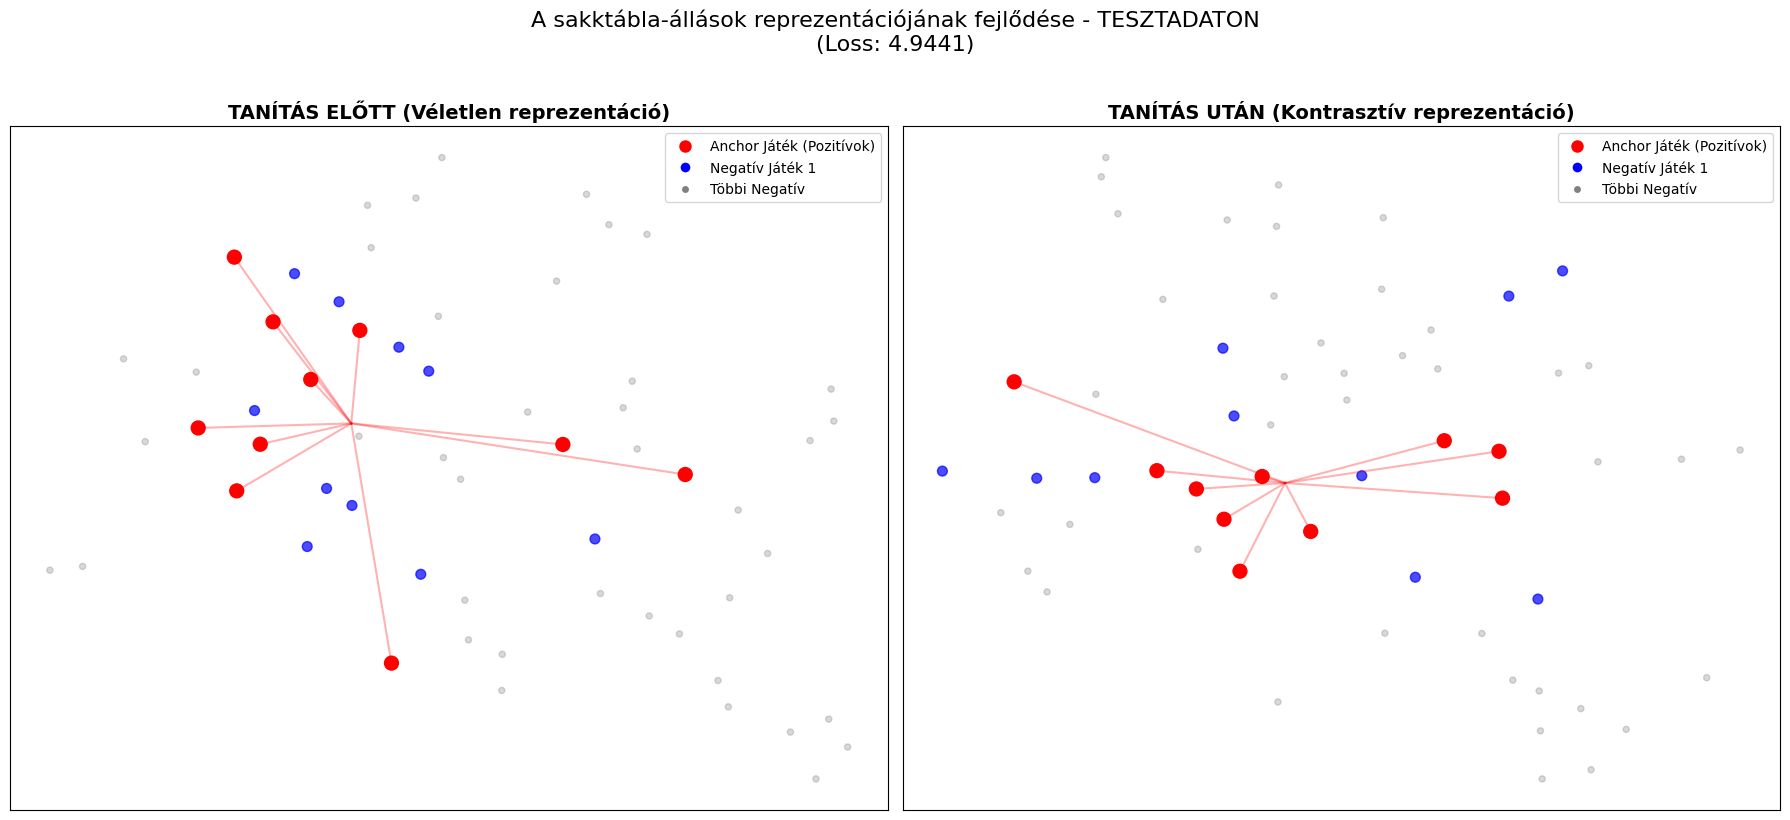

In [ ]:
# VISUALIZATION
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import DataLoader

FILE_PATH = "data/lc0-hidden/lichess_elite_2025-11.h5"
MODEL_PATH = 'data/lc0-hidden/best_chess_model.pth' 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE_VIZ = 6 

print(f"Vizualizáció előkészítése {DEVICE} eszközön...")

loader_viz = DataLoader(test_dataset, batch_size=BATCH_SIZE_VIZ, shuffle=False, num_workers=0)
viz_states_batch = next(iter(loader_viz))
# Kilapítjuk: [6, 10, 64, 8, 8] -> [60, 64, 8, 8]
viz_states_flat = viz_states_batch.view(-1, 64, 8, 8).to(DEVICE)

labels = np.repeat(np.arange(BATCH_SIZE_VIZ), 10)
colors = ['red' if l == 0 else 'blue' if l == 1 else 'gray' for l in labels]
sizes = [100 if l == 0 else 50 if l == 1 else 20 for l in labels]
alphas = [1.0 if l == 0 else 0.7 if l == 1 else 0.3 for l in labels]


model_untrained = ChessEncoder(embedding_dim=128).to(DEVICE)
model_untrained.eval()

model_trained = ChessEncoder(embedding_dim=128).to(DEVICE)
try:
    model_trained.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("Betanított modell súlyai sikeresen betöltve.")
except FileNotFoundError:
    print(f"HIBA: Nem található az elmentett modell az {MODEL_PATH} útvonalon")
model_trained.eval()


# GENERATING EMBEDDINGS & T-SNE
def get_embeddings_and_tsne(model, inputs):
    with torch.no_grad():
        embeddings = model(inputs).cpu().numpy()
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=10, max_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

print("t-SNE futtatása a tanítatlan modellen...")
emb_untrained_2d = get_embeddings_and_tsne(model_untrained, viz_states_flat)

print("t-SNE futtatása a betanított modellen...")
emb_trained_2d = get_embeddings_and_tsne(model_trained, viz_states_flat)


# VISUALIZATION
def plot_embeddings(embeddings_2d, title, ax):
    ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=sizes, alpha=alphas)

    anchor_points = embeddings_2d[0:10]
    centroid = np.mean(anchor_points, axis=0)
    for point in anchor_points:
        ax.plot([centroid[0], point[0]], [centroid[1], point[1]], 'r-', alpha=0.3)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Anchor Játék (Pozitívok)', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Negatív Játék 1', markerfacecolor='blue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Többi Negatív', markerfacecolor='gray', markersize=6),
    ]
    ax.legend(handles=legend_elements, loc='best')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

plot_embeddings(emb_untrained_2d, "TANÍTÁS ELŐTT (Véletlen reprezentáció)", ax1)
plot_embeddings(emb_trained_2d, "TANÍTÁS UTÁN (Kontrasztív reprezentáció)", ax2)

plt.suptitle(f"A sakktábla-állások reprezentációjának fejlődése - TESZTADATON\n(Loss: {best_loss:.4f})", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()